# Word2Vec

# SkipGram Model

## Table of Contents

1. #### **[Import Corpus for inspection](#import_corpus)**

    - [Corpus sample](#corpus_sample)    
    
2. #### **[Vocabulary word-ID mappings](#word2id)**

3. #### **[Generate training samples](#generate_samples)**

4. #### **[Loss Function](#loss)**

5. #### **[SkipGram model](#model)**

6. #### **[Train the model](#train_model)**

7. #### **[Evaluate Embeddings quality](#eval_embeds)**

Adapted from: <br>

Papers / Lectures <br>
https://arxiv.org/pdf/1411.2738.pdf <br>
https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf <br>
http://web.stanford.edu/class/cs224n/lectures/lecture2.pdf <br>
http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/<br>

Code <br>
https://iksinc.online/tag/skip-gram-model/ <br>
https://index.pocketcluster.io/dsksd-deepnlp-models-pytorch.html <br>
https://gist.github.com/lirnli/c6e02efc414b4473abbb8152d303514c <br>
https://github.com/LianHaiMiao/pytorch-lesson-zh/blob/master/NLP/py/word2vec.py <br>

In [1]:
import os
from time import time
%matplotlib inline
%load_ext memory_profiler
import itertools
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from collections import deque
from sklearn.decomposition import PCA
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import functional as F

from glob import glob
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en')
from nltk.tokenize import word_tokenize
from nltk import FreqDist

/home/hveiga/Desktop/Data_Science/dl-venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hveiga/Desktop/Data_Science/dl-venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hveiga/Desktop/Data_Science/dl-venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/home/hveiga/Desktop/Data_Science/dl-venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hveiga/Desktop/Data_Science/dl-venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibi

<a id='import_corpus'></a>
## Import corpus for inspection

In [2]:
path = './aclImdb/train/pos/*.txt'
text = ""

for filename in glob(path):
    with open(filename,'r') as f:
        text += " " + f.read()
              
#with open("./aclImdb/corpus_all_pos.txt", "w+") as f:
#    f.write(text[:75000])
#    f.close()

In [3]:
corpus = [token.text for token in list(nlp.tokenizer(text[:50000]))]
# stop_words = set(stopwords.words('english'))
# corpus = [w for w in corpus if w not in stop_words]

<a id='corpus_sample'></a>
### Corpus sample

In [4]:
print('length of texts: ', len(corpus))
print('number of unique words:', len(set(corpus)))
print('a sample below')
corpus[:10]

length of texts:  10308
number of unique words: 2766
a sample below


[' ',
 'I',
 "'m",
 'grateful',
 'to',
 'Cesar',
 'Montano',
 'and',
 'his',
 'crew',
 'in',
 'reviving',
 'the',
 'once',
 '-',
 'moribund',
 'Visayan',
 'film',
 'understorey',
 '.']

In [5]:
# Word frequency
word_frequency = dict(FreqDist(corpus))

<a id='word2id'></a>
## Vocabulary word-ID mappings

In [6]:
# Word - ID mapping
word2id = {}
for filename in glob(path):
    with open(filename,'r') as f:      
        for line in f: 
            tokens = word_tokenize(line)

            if word2id:
                word2id.update({word:0 for word in tokens})
            else:
                word2id = {word:0 for word in tokens}

for i, (word, value) in enumerate(list(word2id.items())):
    word2id[word] = i

In [7]:
id2word = {i: word for word, i in word2id.items()}
#word_count = len(word2id)

In [8]:
# Probability for a given word i in the corpus
pow_frequency = np.array(list(word_frequency.values()))**0.75
words_pow = sum(pow_frequency) 
p_wi = pow_frequency / words_pow

<a id='generate_samples'></a>
## Generate training samples

#### Input data sample example

<img style="float: left;" src="skipgram-input_data_example.png">

The following class will generate 2 matrices: <br><br>
**center_words** - list of center (input) word IDs - batch x 1 <br>
**context_words** - list of context (neighbour) word IDs - batch x 1 <br>

--> The full vocabulary embedding matrix will be generated during training as no indexing should be performed

This class uses the Pytorch DataLoader logic, which will allow us to generate batches of observations for training on the fly, reading it from multiple files stored in the disk and doing all the necessary processing. This is memory efficient because only one line of the file is being read at a time instead of reading the whole file into memory. Once a line is read, it is discarded from memory and it moves to the next one.

Source: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [9]:
class GenerateDataset(Dataset):
    def __init__(self, window_size, vocab_map, n_docs, transform=None, random_seed=777):
        
        word_pair_catch = deque()
        word_ids = []
        self.center_words = []
        self.context_words = []
        self.transform = transform
        
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
                
        for filename in glob(path)[:n_docs]:
            with open(filename,'r') as f:
                for line in f:
                    word_ids = []
                    for word in word_tokenize(line):
                        word_ids.append(vocab_map[word])

                    for i, u in enumerate(word_ids):
                        for j, v in enumerate(
                                word_ids[max(i - window_size + 1, 0):i + window_size + 1]):            
                            if i == j:
                                continue
                            word_pair_catch.append((u, v))

                    for _ in range(len(word_pair_catch)):
                        _pair = word_pair_catch.popleft()

                        self.center_words.append(_pair[0])
                        self.context_words.append(_pair[1])

                        
    def __getitem__(self, index):
        if self.transform:
            self.center_words = np.array(self.center_words).reshape(-1,1)
            self.context_words = np.array(self.context_words).reshape(-1,1)
            
            return self.transform(self.center_words[index], self.context_words[index])

    def __len__(self):
        return len(self.center_words)

This class will be used as a "transform" in Pytorchs' DataLoader - it will transform the data into Tensors

In [10]:
class ToTensor(object):
    def __call__(self, center_words, context_words):
        center_words = torch.from_numpy(center_words)
        context_words = torch.from_numpy(context_words)      
        
        return center_words, context_words

<a id='loss'></a>
## Loss Function

The average **Negative Log-Likelihood** will be used and is given by:

$$ - \frac{1}{T}  \sum_{t=1}^T  \: \sum_{-c<=j<c, j\neq0} \:\text{log} \: p( {w_{t+j}|w_{t}} ) $$ 

$$ Where: \text{log} \: p( {w_{t+j}|w_{t}} ) = J_\theta $$ 

$$ J_\theta = \text{log}\frac{\exp(h \times v_{w_O}^\top)}{\sum_{i=1}^T \exp(h \times v_{w_i}^\top)} $$

Where: $$w_1, w_2, w_3, \cdots, w_T$$ Are a sequence of T training words that belong to a vocabulary V. <br> 
$$h$$ Is the input word embedding indexed from the embedding matrix with d dimensions. <br>
$$v_{w_O}$$ Is the output vector (embedding vector) for the context word

The formula is adapted for the matrix shapes used in this notebook (x denotes batch matrix multiplication)

<a id='model'></a>
## SkipGram model

In [11]:
random_seed = 777
batch_size = 256
emb_dimension = 3
window_size = 3
n_epochs = 10
learning_rate = 0.01
vocab_size = len(word2id)
n_docs = 30

#### Create dataset in batches for training

In [12]:
imdb_dataset = GenerateDataset(window_size, word2id, n_docs, ToTensor(), random_seed)

In [13]:
imdb_loader = DataLoader(imdb_dataset, 
                         batch_size=batch_size, 
                         shuffle=False,
                         num_workers=0, 
                         drop_last=True)

#### Architecture

<img style="float: left;" src="skip_gram_image.jpg">

Source: https://zhuanlan.zhihu.com/p/30099896

Here to implement the above model we do:
1. Embed the incoming center words (center_embeds)
2. Embed the corresponding context pairs (target_pair_embeds)
3. Embed all the words in the vocabulary (context_embeds)

Then, recalling our **loss function**:
$$ \frac{1}{T}  \sum_{t=1}^T  \: \sum_{-c<=j<c, j\neq0} \: \text{log}\frac{\exp(h \times v_{w_j}^\top)}{\sum_{i=1}^T \exp(h \times v_{w_i}^\top)} $$

5. We multiply **center_embeds** with **target_pair_embeds** --> This gives us the numerator of the loss function (similarity between center word and a given context word)
6. We multiply **center_embeds** with **context_embeds** --> This gives us the denominator of the loss function (similarity between center word and a given context word, but here we do it for all the words in the corpus and sum the result)
7. Divide **step 5** result by **step 6** result and apply the **log** (we get log_softmax)
8. Calculate the average (here effectively it will be the average of the batch)

In [14]:
class SkipGram_Model(nn.Module):
    def __init__(self, vocab_map, vocab_size, emb_dimension, random_seed):
        super(SkipGram_Model, self).__init__()
        self.random_seed = random_seed
        self.emb_dimension = emb_dimension
        self.center_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=True)
        self.context_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=True)
        self.vocab_tensor = torch.from_numpy(np.array(list(vocab_map.values())).reshape(1,-1))
        self.vocab_tensor = self.vocab_tensor.expand(batch_size, vocab_size) 
        if torch.cuda.is_available():
            self.vocab_tensor = self.vocab_tensor.cuda()
            
        self.init_emb()
        
    def init_emb(self):
        """Initialize embedding weights like word2vec.
        The center_embeddings is a uniform distribution in [-0.5/em_size, 0.5/emb_size], 
        and the elements of context_embeddings are zeros.
        """        
        torch.manual_seed(self.random_seed)
        initrange = 0.5 / self.emb_dimension
        self.center_embeddings.weight.data.uniform_(-initrange, initrange)
        self.context_embeddings.weight.data.uniform_(-0, 0)

    def forward(self, center_words, context_words):       

        center_embeds = self.center_embeddings(center_words)      # Batch x 1 x Emb Dim
        target_pair_embeds = self.context_embeddings(context_words) # Batch x 1 x Emb Dim
        context_embeds = self.context_embeddings(self.vocab_tensor) # Batch x vocab_size x Emb Dim                                   

        scores = torch.bmm(center_embeds, 
                                   target_pair_embeds.transpose(1,2)).squeeze(-1) # Batch x 1

        full_context_embeds = torch.bmm(center_embeds, 
                                        context_embeds.transpose(1,2)).squeeze(1) # Batch x vocab_size
        
        log_softmax = torch.log(torch.exp(scores)/torch.sum(torch.exp(full_context_embeds), 1).unsqueeze(1))
        nll = -torch.mean(log_softmax)        

        return nll
    
    def return_embeds(self):
        word_embeds = self.center_embeddings.weight.cpu().data.numpy()
        
        return word_embeds    

#### Instantiate model and optimizer

In [15]:
model = SkipGram_Model(word2id, vocab_size, emb_dimension, random_seed)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=learning_rate)

#### Use GPU if available

In [16]:
if torch.cuda.is_available():
    model.cuda()

<a id='train_model'></a>
## Train the model

In [17]:
def train_model(n_epochs, data_loader, model):
    plot_train = []
    save_loss = []
    
    for epoch in range(n_epochs):
        start = time()
        losses = []
        for batch_idx, (center_words, context_words) in enumerate(data_loader):

            ##### Use GPU if available #####
            if torch.cuda.is_available():
                center_words = center_words.cuda()
                context_words = context_words.cuda()

            # forward, backward, apply gradients
            optimizer.zero_grad()        
            loss = model.forward(center_words, context_words)
            loss.backward()
            optimizer.step()                          

            # save loss
            losses.append(loss.item())
        end = time()
        save_loss.append(np.mean(losses))
        
        if epoch%1 == 0:
            print('epoch {}, epoch_loss {}, runtime {}'.format(epoch, np.mean(losses), end-start))

    
    pd.Series(save_loss).plot()              

epoch 0, epoch_loss 10.109540753248261, runtime 190.23959064483643
epoch 1, epoch_loss 8.033014502951769, runtime 190.26353096961975
epoch 2, epoch_loss 7.430593387867377, runtime 189.8552656173706
epoch 3, epoch_loss 7.013319597011659, runtime 189.90188670158386
epoch 4, epoch_loss 6.686399440455243, runtime 189.85353803634644
epoch 5, epoch_loss 6.441255769109338, runtime 189.87725687026978
epoch 6, epoch_loss 6.259713432653164, runtime 189.77540111541748
epoch 7, epoch_loss 6.143945916881406, runtime 189.9020538330078
epoch 8, epoch_loss 6.082356604134164, runtime 189.84843158721924
epoch 9, epoch_loss 6.0483185333934255, runtime 189.8670358657837


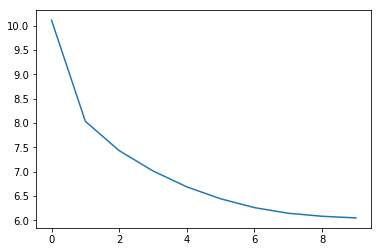

In [18]:
train_model(n_epochs, imdb_loader, model)

<a id='eval_embeds'></a>
## Evaluate Embeddings quality

In [19]:
def get_encoding(word, word_dict, embedding):
    return embedding[word2id[word]]

In [20]:
def word_similarity(word1, word2):
    params = {"word_dict":word2id, 
              "embedding":model.return_embeds()}
    v1 = get_encoding(word1, **params)
    v2 = get_encoding(word2, **params)
    res = 1 - cosine(v1,v2)
    return res

In [21]:
def word_scatter(xs, labels,fontsize=14):
    for i, t in enumerate(labels):
        plt.annotate(t,xs[i],fontsize=fontsize)

In [22]:
pca = PCA(n_components=2)

#### Word similarity

Text(0.5,1,'PCA transformation of word vector')

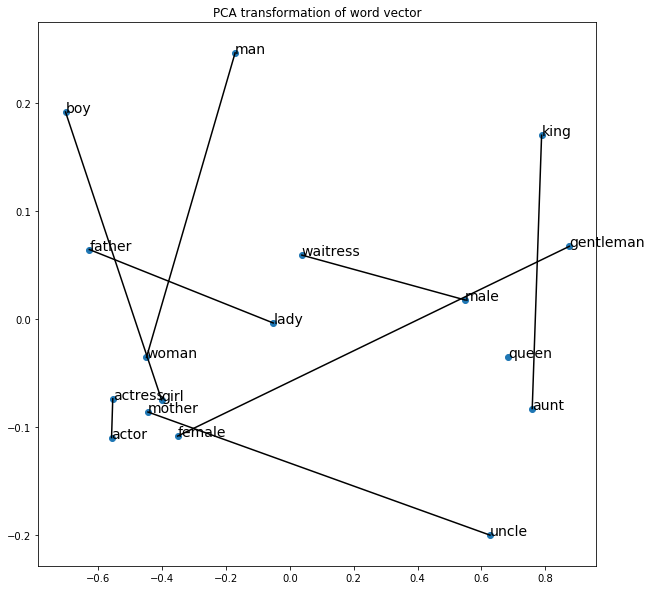

In [23]:
plt.figure(figsize=[10,10])
labels = 'man woman boy girl actor actress waitress male female gentleman lady father mother uncle aunt king queen'.split()

coords = [word2id[w] for w in labels]
coords = (model.return_embeds()[coords,:]

y_scatter = pca.fit_transform(coords)
plt.scatter(y_scatter[:,0], y_scatter[:,1])
word_scatter(y_scatter, labels)

for i in range(0,y_scatter.shape[0],2):
    plt.plot(y_scatter[i:i+2,0],y_scatter[i:i+2,1],'black')
          
plt.title('PCA transformation of word vector')

In [24]:
print('nice','good', word_similarity('nice','good'))
print('dog','cat', word_similarity('dog','cat'))
print('dog','animal', word_similarity('dog','animal'))
print('cat','animal', word_similarity('cat','animal'))
print('good','fantastic', word_similarity('good','fantastic'))
print('good','terrible', word_similarity('good','terrible'))
print('mother','father', word_similarity('mother','father'))
print('king','queen', word_similarity('king','queen'))
print('boy','girl', word_similarity('boy','girl'))
print('hate','love', word_similarity('hate','love'))
print('ugly','beautiful', word_similarity('ugly','beautiful'))
print('angry','happy', word_similarity('angry','happy'))
print('do','did', word_similarity('do','did'))
print('do','does', word_similarity('do','does'))
print('do','done', word_similarity('do','done'))

nice good 0.8768650889396667
dog cat 0.1568123698234558
dog animal -0.7843129634857178
cat animal 0.39451807737350464
good fantastic 0.8710890412330627
good terrible 0.9093095660209656
mother father 0.9917430877685547
king queen -0.8747478723526001
boy girl 0.9702117443084717
hate love 0.3045463263988495
ugly beautiful 0.43248552083969116
angry happy 0.4419500231742859
do did 0.9942993521690369
do does 0.9706856608390808
do done 0.9681901335716248


#### test examples

for idx, (center_words, context_words) in enumerate(imdb_loader):
    if idx==0:        
        torch.manual_seed(random_seed)
        
        vocab_tensor = torch.from_numpy(np.array(list(word2id.values())).reshape(1,-1))
        vocab_tensor = vocab_tensor.expand(batch_size, vocab_size)        

        emb_dimension = emb_dimension
        center_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=True)
        context_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=True)

        center_embeds = center_embeddings(center_words)      # Batch x 1 x Emb Dim
        target_pair_embeds = context_embeddings(context_words) # Batch x 1 x Emb Dim
        context_embeds = context_embeddings(vocab_tensor)      # Batch x vocab_size x Emb Dim                                   

        scores = torch.bmm(center_embeds, 
                                   target_pair_embeds.transpose(1,2)).squeeze(-1) # Batch x 1
        
        full_context_embeds = torch.bmm(center_embeds, 
                                        context_embeds.transpose(1,2)).squeeze(1) # Batch x vocab_size
        
        print("Center word embedding")
        print(center_embeds.size())
        print(center_embeds)
        print([id2word[j[0]] for j in list(center_words[:5].numpy())])
        print()
        print("Target word embeddings")
        print(target_pair_embeds.size())
        print(target_pair_embeds)
        print()
        print("context_embeds")
        print(context_embeds.size())
        print(context_embeds)
        print([id2word[j[0]] for j in list(context_words[:5].numpy())])
        print()
        
        for i in range(1):
            print(torch.dot(center_embeds[0].squeeze(), target_pair_embeds[0][i].squeeze()).item())
            
        print()
        
        for i in range(1):
            print(torch.dot(center_embeds[1].squeeze(), target_pair_embeds[1][i].squeeze()).item())        
         
        print()
        
        for i in range(6):
            print(torch.dot(center_embeds[0].squeeze(), context_embeds[0][i].squeeze()).item())        
        print()  
        
        for i in range(6):
            print(torch.dot(center_embeds[1].squeeze(), context_embeds[0][i].squeeze()).item())        
        print()        
        
        print(full_context_embeds)

    else:
        break